# Convolutional Neural Network and LSTM Implementations

Note about running the code: 
- Make sure you have all the required libraries installed.
- The code is written in Python 3.9
- To replicate the results, use the data files in the Directory: Sensor Data Cleaned.
- Remember that Sensor Data Cleaned directory should be in the same directory as this notebook, however Sensor Data Cleaned directory is not the final cleaned data we end up using for the final rendition of the regression models and classification models.

In [2]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
# Load the cleaned dataset
sensor_data = pd.read_csv('Sensor Data Cleaned/cleaned_non_normalized_final_sensor_stress_data_no_missing.csv')
sensor_data.rename(columns={'PSS_10items_POST': 'stress_score'}, inplace=True)

# Convert the 'date' column to datetime format and extract the year
sensor_data['year'] = pd.to_datetime(sensor_data['date']).dt.year

# Split the data into training and testing sets
train_data = sensor_data[sensor_data['year'].isin([2018, 2019, 2020])]
test_data = sensor_data[sensor_data['year'] == 2021]

# Drop unnecessary columns (pid, date, and year) for feature extraction
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score']]

# Prepare training features and target
X_train = train_data[features_columns].values
y_train = train_data['stress_score'].values

# Prepare testing features and target
X_test = test_data[features_columns].values
y_test = test_data['stress_score'].values

# Scale the non-normalized data using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Calculate the number of samples for reshaping
num_timesteps = 71
num_samples_train = X_train_tensor.shape[0] // num_timesteps
num_samples_test = X_test_tensor.shape[0] // num_timesteps

# Ensure we only keep complete sequences
X_train_tensor = X_train_tensor[:num_samples_train * num_timesteps]
y_train_tensor = y_train_tensor[:num_samples_train * num_timesteps]

X_test_tensor = X_test_tensor[:num_samples_test * num_timesteps]
y_test_tensor = y_test_tensor[:num_samples_test * num_timesteps]

# Reshape the tensors to fit the CNN input format
# Reshape to (samples, timesteps, features)
num_features = X_train_tensor.shape[1]

X_train_tensor = X_train_tensor.view(num_samples_train, num_timesteps, num_features)
y_train_tensor = y_train_tensor.view(num_samples_train, num_timesteps).mean(dim=1)

X_test_tensor = X_test_tensor.view(num_samples_test, num_timesteps, num_features)
y_test_tensor = y_test_tensor.view(num_samples_test, num_timesteps).mean(dim=1)

# Print tensor shapes for verification
print(f'Training features tensor shape: {X_train_tensor.shape}')
print(f'Training target tensor shape: {y_train_tensor.shape}')
print(f'Testing features tensor shape: {X_test_tensor.shape}')
print(f'Testing target tensor shape: {y_test_tensor.shape}')

# Ensure training and testing tensors are properly sized
if len(y_train_tensor.shape) == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
if len(y_test_tensor.shape) == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)

# Ensure feature and target tensors have compatible sizes
assert X_train_tensor.size(0) == y_train_tensor.size(0), "Mismatch in number of training samples between features and targets"
assert X_test_tensor.size(0) == y_test_tensor.size(0), "Mismatch in number of testing samples between features and targets"

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training features tensor shape: torch.Size([331, 71, 23])
Training target tensor shape: torch.Size([331])
Testing features tensor shape: torch.Size([140, 71, 23])
Testing target tensor shape: torch.Size([140])


Epoch [1/500], Loss: 383.5372
Test Loss: 343.1208
Epoch [2/500], Loss: 376.3510
Test Loss: 343.1208
Epoch [3/500], Loss: 379.2634
Test Loss: 343.1208
Epoch [4/500], Loss: 374.5558
Test Loss: 343.1208
Epoch [5/500], Loss: 378.5367
Test Loss: 343.1208
Epoch [6/500], Loss: 385.0504
Test Loss: 343.1208
Epoch [7/500], Loss: 383.6023
Test Loss: 343.1208
Epoch [8/500], Loss: 377.7394
Test Loss: 343.1208
Epoch [9/500], Loss: 373.8833
Test Loss: 343.1208
Epoch [10/500], Loss: 376.6981
Test Loss: 343.1208
Epoch [11/500], Loss: 382.6532
Test Loss: 343.1208
Epoch [12/500], Loss: 382.7182
Test Loss: 343.1208
Epoch [13/500], Loss: 386.2815
Test Loss: 343.1208
Epoch [14/500], Loss: 386.8456
Test Loss: 343.1208
Epoch [15/500], Loss: 383.5209
Test Loss: 343.1208
Epoch [16/500], Loss: 389.6170
Test Loss: 343.1208
Epoch [17/500], Loss: 384.6707
Test Loss: 343.1208
Epoch [18/500], Loss: 377.8425
Test Loss: 343.1208
Epoch [19/500], Loss: 380.7983
Test Loss: 343.1208
Epoch [20/500], Loss: 379.3448
Test Loss

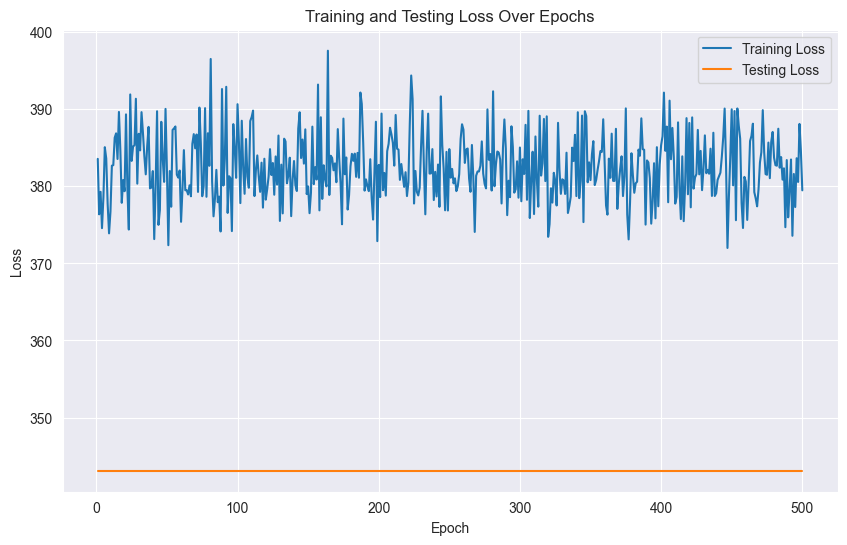

Final Test Loss: 343.1208


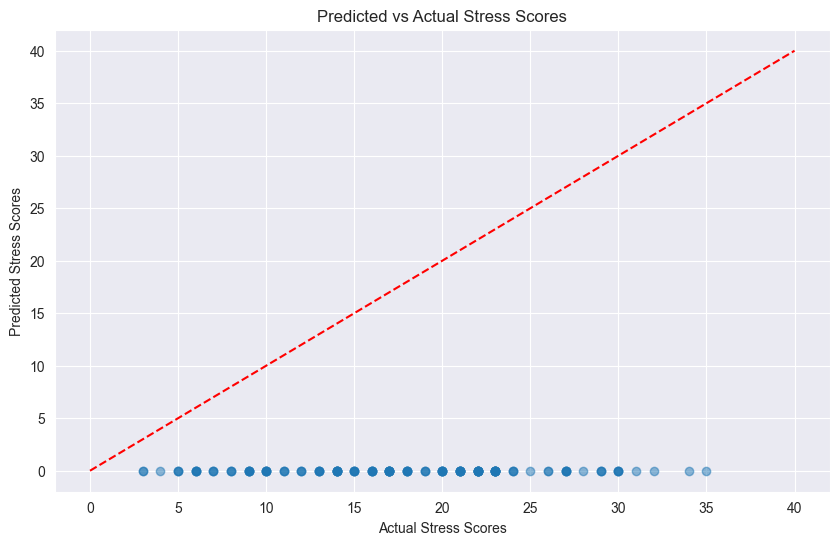

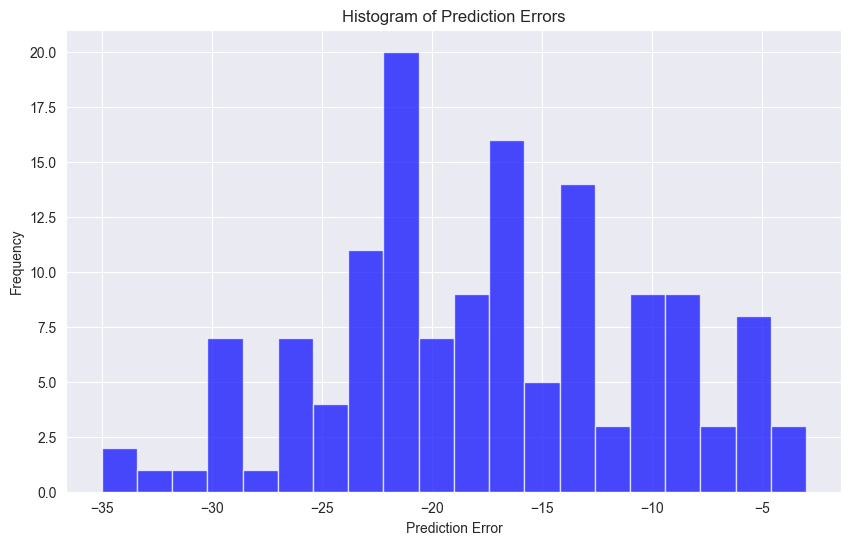

In [11]:


# Define the CNN model
class StressCNN(nn.Module):
    def __init__(self, input_features, num_timesteps):
        super(StressCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.flatten_size = 32 * num_timesteps
        self.fc1 = nn.Linear(self.flatten_size, 64)
        self.fc2 = nn.Linear(64, 1)  # Output a single stress score

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, features, timesteps)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.clamp(x, 0, 40)  # Ensure the output is between 0 and 40
        x = torch.round(x)  # Snap the output to an integer value
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check for mismatched sizes and reshape if necessary
if len(y_train_tensor.shape) == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
if len(y_test_tensor.shape) == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model, define loss function and optimizer
num_features = X_train_tensor.shape[2]
num_timesteps = X_train_tensor.shape[1]
model = StressCNN(input_features=num_features, num_timesteps=num_timesteps).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 500
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch.squeeze())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}')

    # Evaluate on test set at the end of each epoch
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.squeeze())
            test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f'Test Loss: {avg_test_loss:.4f}')

# Plot training and testing loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    test_loss = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch.squeeze())
        test_loss += loss.item()

        all_preds.extend(outputs.squeeze().cpu().numpy())
        all_targets.extend(y_batch.squeeze().cpu().numpy())

    print(f'Final Test Loss: {test_loss/len(test_loader):.4f}')

# Scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.xlabel('Actual Stress Scores')
plt.ylabel('Predicted Stress Scores')
plt.title('Predicted vs Actual Stress Scores')
plt.plot([0, 40], [0, 40], color='red', linestyle='--')  # Reference line
plt.show()

# Histogram of prediction errors (residuals)
residuals = [pred - target for pred, target in zip(all_preds, all_targets)]
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


Epoch [1/60], Loss: 181.9634
Test Loss: 68.0505
Epoch [2/60], Loss: 64.8672
Test Loss: 61.8825
Epoch [3/60], Loss: 49.3773
Test Loss: 51.4704
Epoch [4/60], Loss: 43.6862
Test Loss: 56.0362
Epoch [5/60], Loss: 42.8567
Test Loss: 52.6221
Epoch [6/60], Loss: 41.9044
Test Loss: 50.7893
Epoch [7/60], Loss: 40.6764
Test Loss: 55.9013
Epoch [8/60], Loss: 43.9610
Test Loss: 50.2336
Epoch [9/60], Loss: 41.5911
Test Loss: 50.3930
Epoch [10/60], Loss: 39.3726
Test Loss: 50.2510
Epoch [11/60], Loss: 40.4883
Test Loss: 49.6209
Epoch [12/60], Loss: 39.4079
Test Loss: 49.3073
Epoch [13/60], Loss: 40.1443
Test Loss: 53.5890
Epoch [14/60], Loss: 38.4056
Test Loss: 63.1675
Epoch [15/60], Loss: 39.7115
Test Loss: 52.0494
Epoch [16/60], Loss: 39.3878
Test Loss: 51.2619
Epoch [17/60], Loss: 38.5099
Test Loss: 48.7411
Epoch [18/60], Loss: 39.9136
Test Loss: 48.9669
Epoch [19/60], Loss: 38.5686
Test Loss: 48.7903
Epoch [20/60], Loss: 40.4798
Test Loss: 57.6132
Epoch [21/60], Loss: 43.0346
Test Loss: 62.7118


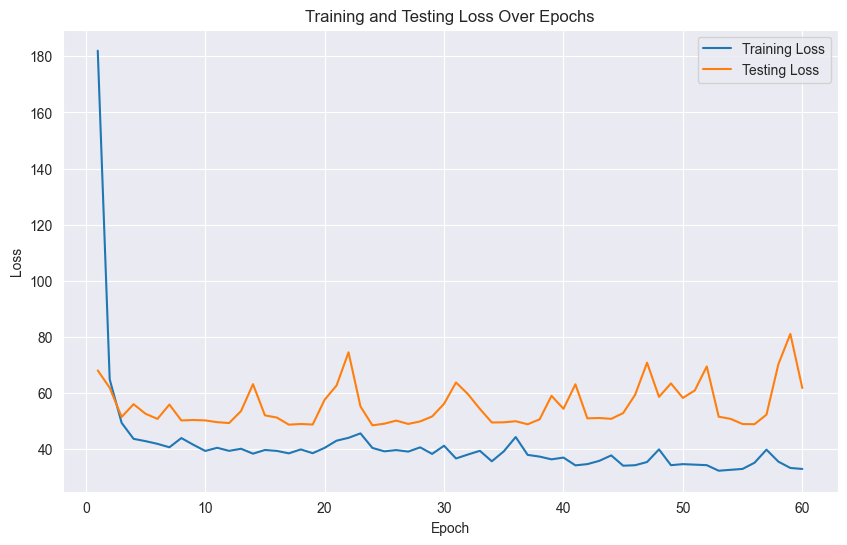

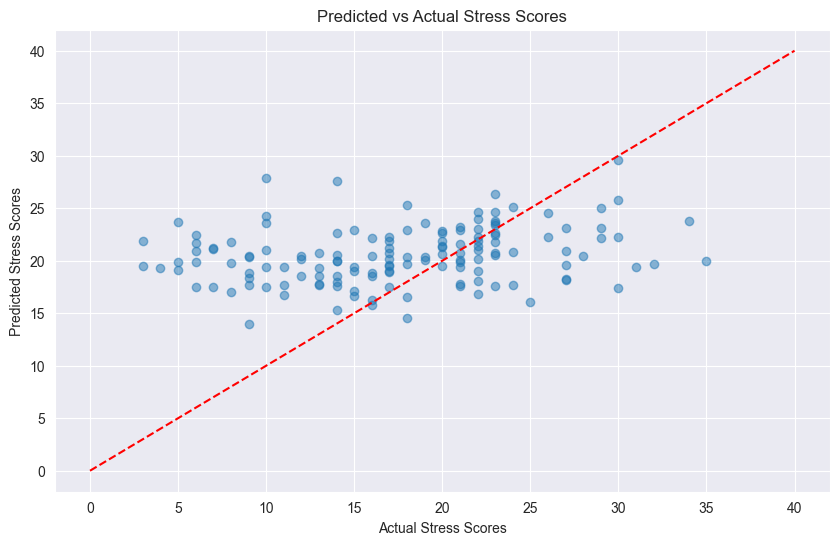

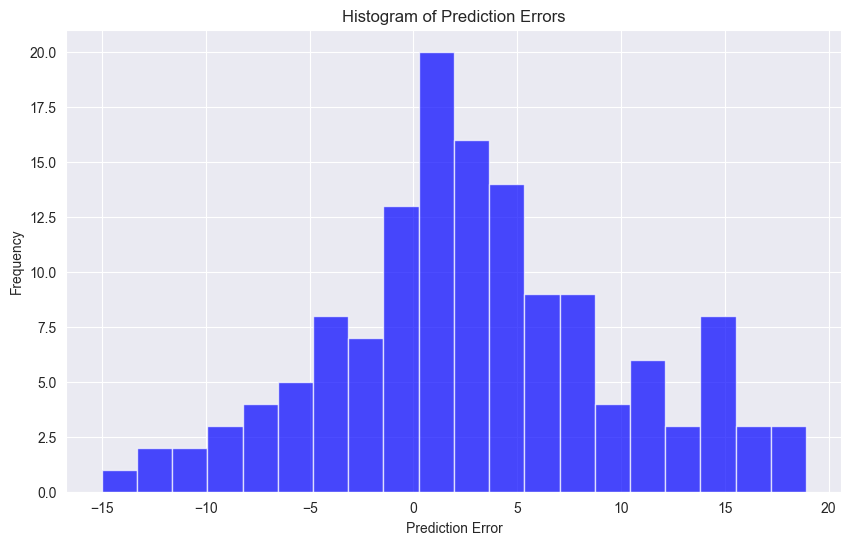

In [20]:
# Define the simplified CNN model
class SimpleStressCNN(nn.Module):
    def __init__(self, input_features, num_timesteps):
        super(SimpleStressCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=8, kernel_size=3)
        self.relu = nn.ReLU()
        self.flatten_size = 8 * (num_timesteps - 2)  # Since kernel_size = 3, timesteps reduce by 2 after conv1
        self.fc1 = nn.Linear(self.flatten_size, 1)  # Output a single stress score

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, features, timesteps)
        x = self.relu(self.conv1(x))
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        x = self.fc1(x)
        x = torch.clamp(x, 0, 40)  # Ensure the output is between 0 and 40
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check for mismatched sizes and reshape if necessary
if len(y_train_tensor.shape) == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
if len(y_test_tensor.shape) == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model, define loss function and optimizer
num_features = X_train_tensor.shape[2]
num_timesteps = X_train_tensor.shape[1]
model = SimpleStressCNN(input_features=num_features, num_timesteps=num_timesteps).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 60
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch.squeeze())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}')

    # Evaluate on test set at the end of each epoch
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.squeeze())
            test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f'Test Loss: {avg_test_loss:.4f}')

# Plot training and testing loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)

        all_preds.extend(outputs.squeeze().cpu().numpy())
        all_targets.extend(y_batch.squeeze().cpu().numpy())

# Scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.xlabel('Actual Stress Scores')
plt.ylabel('Predicted Stress Scores')
plt.title('Predicted vs Actual Stress Scores')
plt.plot([0, 40], [0, 40], color='red', linestyle='--')  # Reference line
plt.show()

# Histogram of prediction errors (residuals)
residuals = [pred - target for pred, target in zip(all_preds, all_targets)]
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


Epoch [1/100], Loss: 345.0380
Test Loss: 215.7165
Epoch [2/100], Loss: 116.4725
Test Loss: 101.3393
Epoch [3/100], Loss: 51.3840
Test Loss: 55.7643
Epoch [4/100], Loss: 47.5308
Test Loss: 55.8676
Epoch [5/100], Loss: 42.3852
Test Loss: 49.5439
Epoch [6/100], Loss: 41.4386
Test Loss: 50.6625
Epoch [7/100], Loss: 42.5407
Test Loss: 51.1080
Epoch [8/100], Loss: 40.8646
Test Loss: 50.2594
Epoch [9/100], Loss: 42.5064
Test Loss: 54.5612
Epoch [10/100], Loss: 41.5365
Test Loss: 48.9598
Epoch [11/100], Loss: 43.6356
Test Loss: 50.8959
Epoch [12/100], Loss: 39.2886
Test Loss: 49.8866
Epoch [13/100], Loss: 40.8338
Test Loss: 49.3555
Epoch [14/100], Loss: 43.0019
Test Loss: 57.0517
Epoch [15/100], Loss: 40.7060
Test Loss: 48.4412
Epoch [16/100], Loss: 40.2416
Test Loss: 48.7371
Epoch [17/100], Loss: 42.7820
Test Loss: 60.9889
Epoch [18/100], Loss: 39.8507
Test Loss: 48.7560
Epoch [19/100], Loss: 40.7792
Test Loss: 49.9474
Epoch [20/100], Loss: 42.1001
Test Loss: 65.2060
Epoch [21/100], Loss: 43.

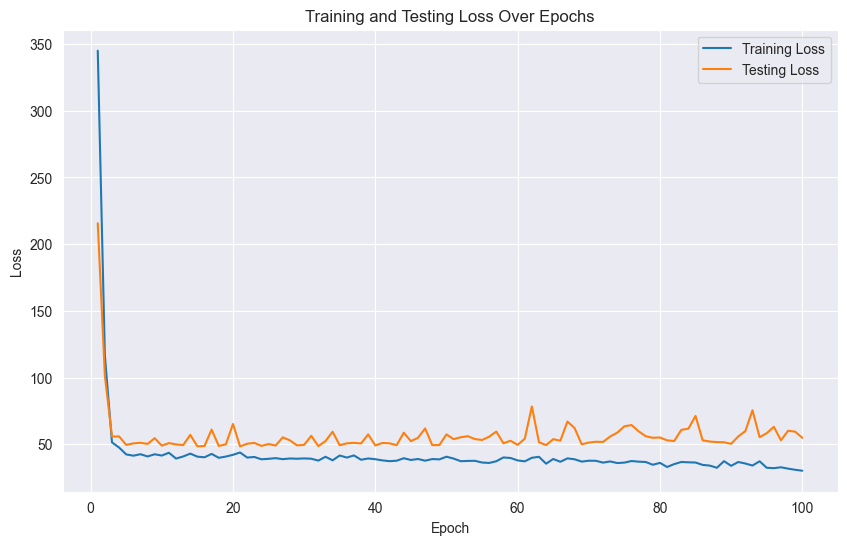

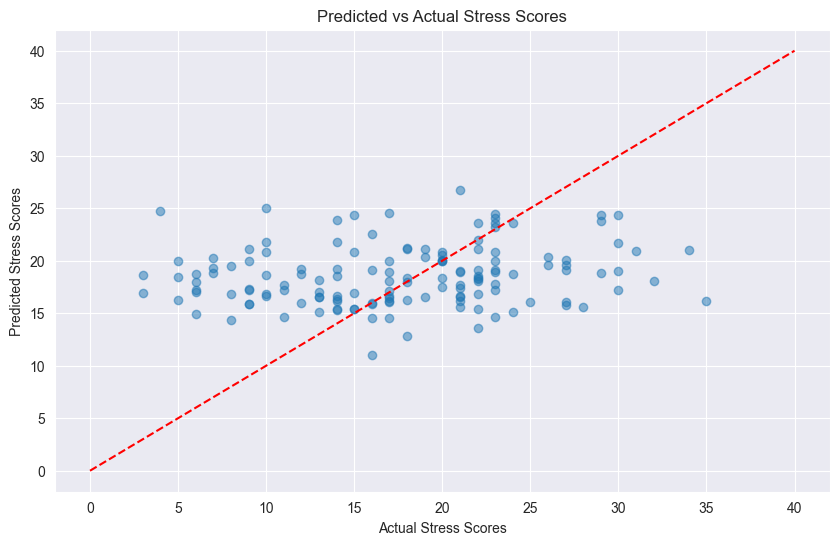

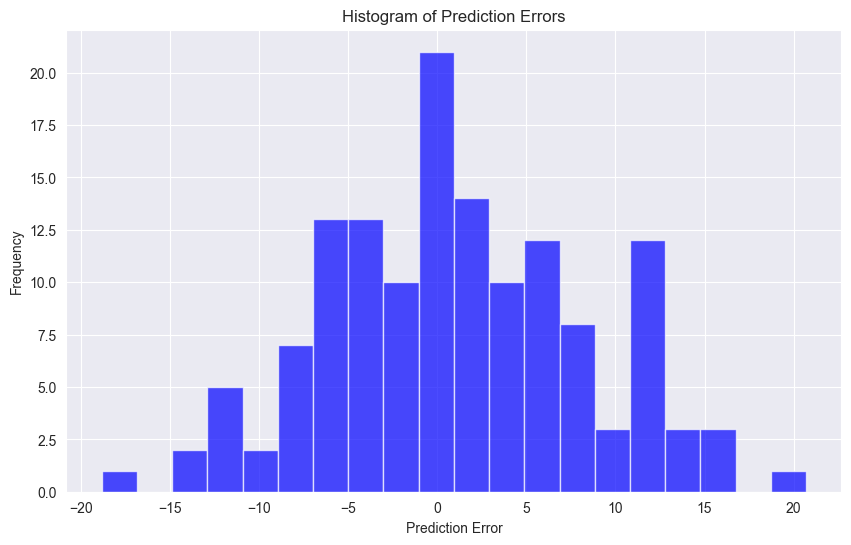

In [21]:
# Define an enhanced CNN model
class EnhancedStressCNN(nn.Module):
    def __init__(self, input_features, num_timesteps):
        super(EnhancedStressCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)  # Pooling layer to reduce size and control overfitting
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Third convolutional layer for additional depth
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
        # Fully connected layers
        self.flatten_size = 64 * (num_timesteps // 2 // 2)  # Adjusted for pooling layers
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 1)  # Output a single stress score

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, features, timesteps)
        # Convolutional layers with activation and pooling
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        # Flatten for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.clamp(x, 0, 40)  # Ensure the output is between 0 and 40
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create data loaders (same as before)
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the enhanced model, define loss function and optimizer
num_features = X_train_tensor.shape[2]
num_timesteps = X_train_tensor.shape[1]
model = EnhancedStressCNN(input_features=num_features, num_timesteps=num_timesteps).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (same as before)
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch.squeeze())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}')

    # Evaluate on test set at the end of each epoch
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.squeeze())
            test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f'Test Loss: {avg_test_loss:.4f}')

# Plot training and testing loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation (similar to previous code)
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)

        all_preds.extend(outputs.squeeze().cpu().numpy())
        all_targets.extend(y_batch.squeeze().cpu().numpy())

# Scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.xlabel('Actual Stress Scores')
plt.ylabel('Predicted Stress Scores')
plt.title('Predicted vs Actual Stress Scores')
plt.plot([0, 40], [0, 40], color='red', linestyle='--')  # Reference line
plt.show()

# Histogram of prediction errors (residuals)
residuals = [pred - target for pred, target in zip(all_preds, all_targets)]
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


Checking why we are getting poor perfomance
Steps to Diagnose and Improve

- Examine Feature Relevance and Data Quality:
    Feature Engineering:
        Consider generating new features that better capture patterns from sensor data, such as activity variability, sleep quality metrics, or transition counts between different states (e.g., sleep-to-active).
        Aggregate and smoothen the data to understand trends rather than focusing on daily values alone.
    Correlation Analysis: Perform an in-depth analysis of feature importance or correlation with the target variable. Features with weak or no correlation should be reconsidered.

- Reevaluate Model Architecture:
    If a CNN is not showing much improvement, consider using an LSTM (Long Short-Term Memory) model instead of a CNN, as LSTMs are better suited to capturing temporal patterns in time-series data.
    Alternatively, explore using a hybrid model, such as a CNN-LSTM, where CNN is used for feature extraction and LSTM for temporal analysis.

- Address Data Complexity:
    Data Augmentation: If we have fewer samples, create synthetic data points using data augmentation or some other means to improve the generalization.
    More Granular Data Representation: Instead of summary statistics, try using sliding windows of time-series data, where each sample corresponds to a short time interval (e.g., a week). This can help the model capture temporal dynamics.

- Revisit Data Normalization and Imputation:
    Normalization Strategies: Since you have normalized some features, check if normalization caused some features to lose valuable information. Try using standardization (z-score normalization) or applying different normalization for different features.
    Inspect Imputation Quality: Evaluate the impact of the chosen imputation methods. Forward and backward fill might not always be ideal if the data is missing for extended periods. Try interpolation or more sophisticated imputation techniques to fill gaps.

- Hyperparameter Tuning and Regularization:
    Learning Rate and Optimizer: Experiment with a lower learning rate or different optimizers, like SGD instead of Adam. A high learning rate may prevent the model from converging effectively.
    Regularization: Introduce additional regularization, such as weight decay or dropout at different stages of the network, to encourage better generalization.

- Classify Stress Instead of Regression:
    Instead of predicting the exact stress score, consider classifying stress levels into different categories (e.g., low, medium, high). This may simplify the task for the model and result in better performance.
    Use metrics like precision, recall, F1-score, and confusion matrix to better assess model performance if you switch to classification.

Some Practical Next Steps

- Feature Relevance Analysis:
    Perform a feature importance analysis using simple models, like Random Forest or Linear Regression, to identify the most important features related to stress levels.
    Visualize feature distributions and correlations with the target variable.

- Shift to LSTM or Hybrid Model:
    Try LSTM or a CNN-LSTM model to see if capturing temporal dependencies in the data improves predictions.
    LSTMs can better manage sequences and temporal relationships, which may be crucial for the given dataset.

- Model Complexity Analysis:
    Reduce the complexity of the CNN to see if overfitting is occurring.
    Experiment with smaller models initially to gauge if the dataset supports such levels of complexity.

- Look at Other Metrics:
    Loss metrics may not tell the complete story of model performance.
    Consider R-squared value, mean absolute error, and distribution of residuals to gain further insight into model performance and possible issues.

- Data Resampling:
    If you see significant imbalance or clustering in the target variable, consider resampling the dataset to give the model more balanced exposure to different ranges of stress scores.
    Resampling can help address situations where the model predicts only average scores due to imbalanced training.

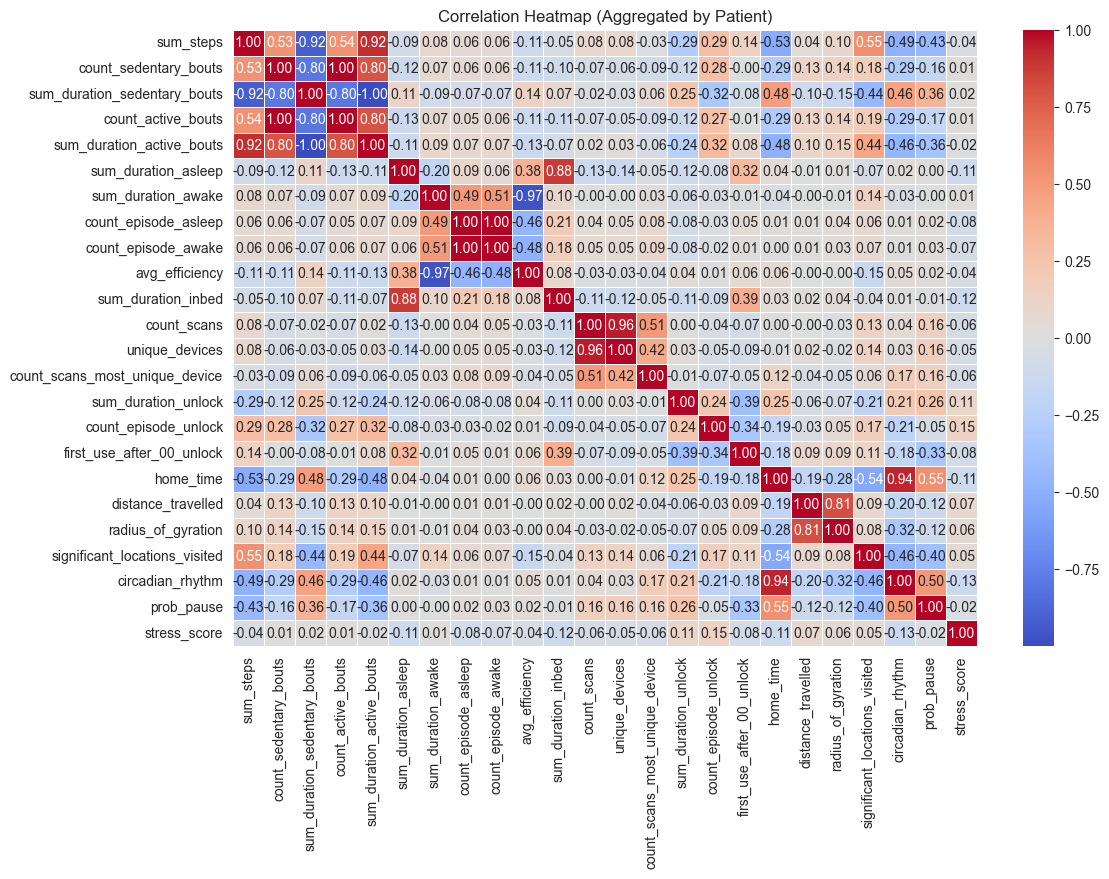

In [23]:
import seaborn as sns

# List of features to aggregate
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score']]

# Aggregate features by patient ID (taking the mean for each patient)
aggregated_data = sensor_data.groupby('pid')[features_columns].mean()

# Add the stress score to the aggregated data (since it's constant for each patient)
aggregated_data['stress_score'] = sensor_data.groupby('pid')['stress_score'].first()

# Calculate the correlation matrix for the aggregated data
corr_matrix = aggregated_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Aggregated by Patient)')
plt.show()


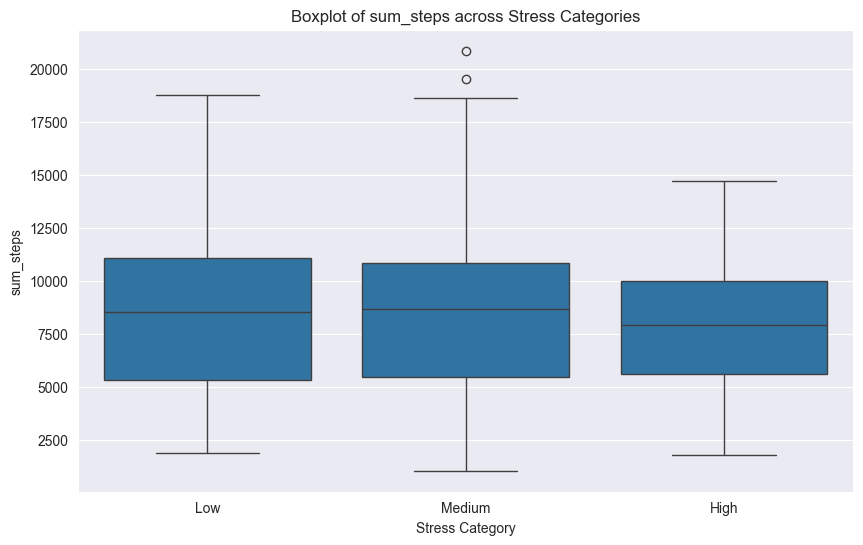

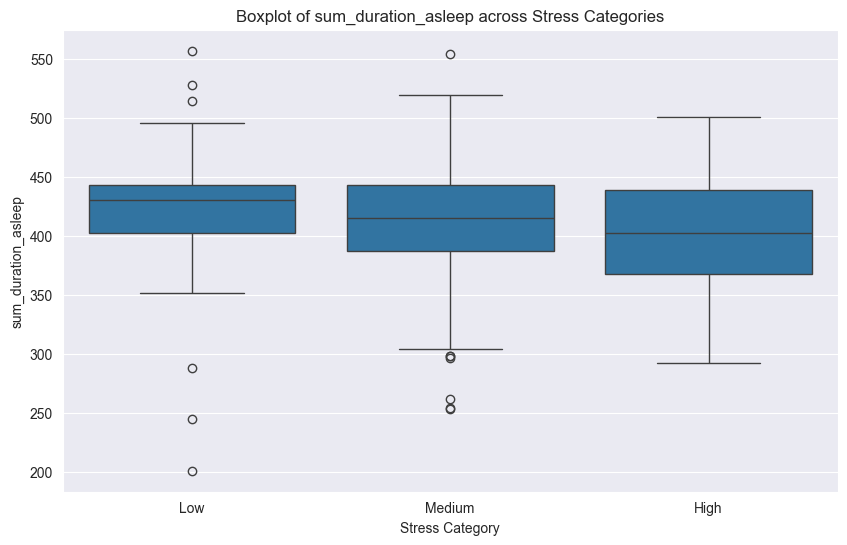

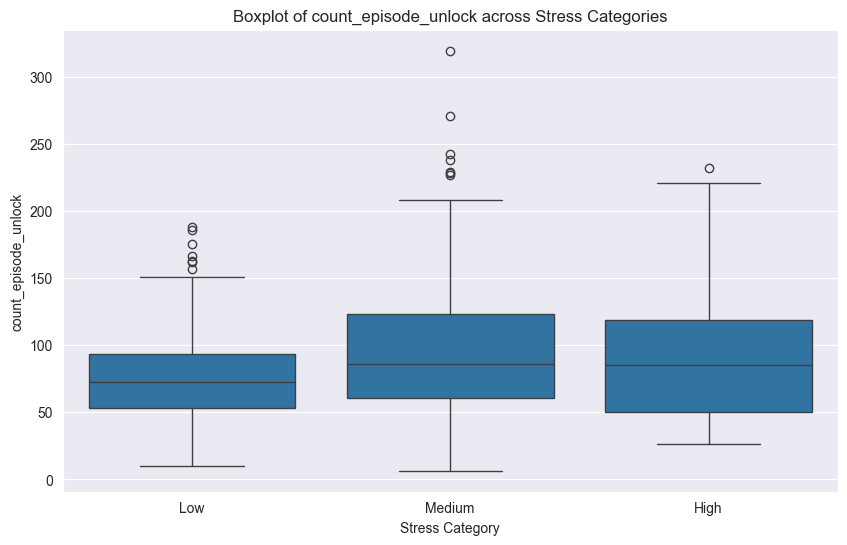

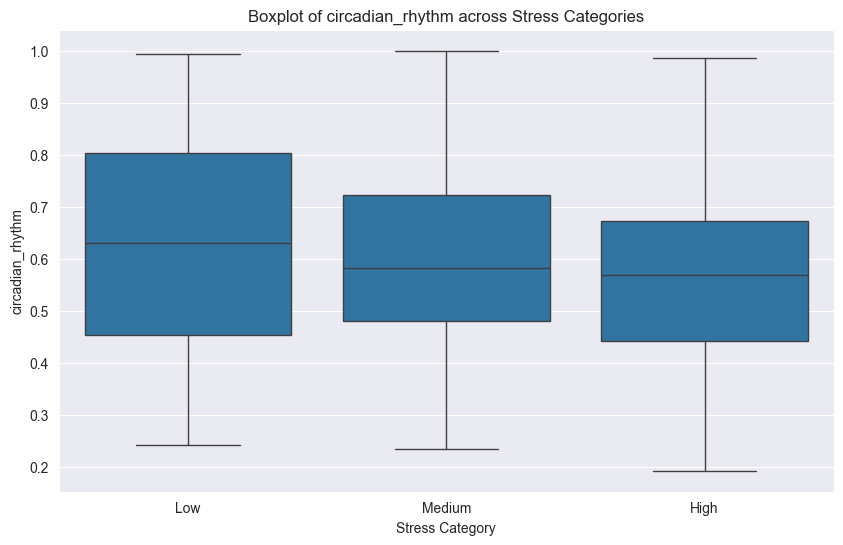

In [26]:
# Convert stress score into bins to categorize as low, medium, and high stress
sensor_data['stress_category'] = pd.cut(sensor_data['stress_score'], bins=[0, 13, 26, 40], labels=['Low', 'Medium', 'High'])

# List of features to aggregate
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score', 'stress_category']]

# Aggregate features by patient ID (taking the mean for each patient)
aggregated_data = sensor_data.groupby('pid')[features_columns].mean()

# Add stress score and category to the aggregated data
aggregated_data['stress_score'] = sensor_data.groupby('pid')['stress_score'].first()
aggregated_data['stress_category'] = sensor_data.groupby('pid')['stress_category'].first()

# Selected features to visualize
selected_features = ['sum_steps', 'sum_duration_asleep', 'count_episode_unlock', 'circadian_rhythm']

# Boxplots for selected features against the stress category
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='stress_category', y=feature, data=aggregated_data)
    plt.title(f'Boxplot of {feature} across Stress Categories')
    plt.xlabel('Stress Category')
    plt.ylabel(feature)
    plt.show()

/var/folders/f_/gv9ztf6972s0pmw0mkbfw0vc0000gn/T/ipykernel_16988/2957998598.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, palette='viridis')


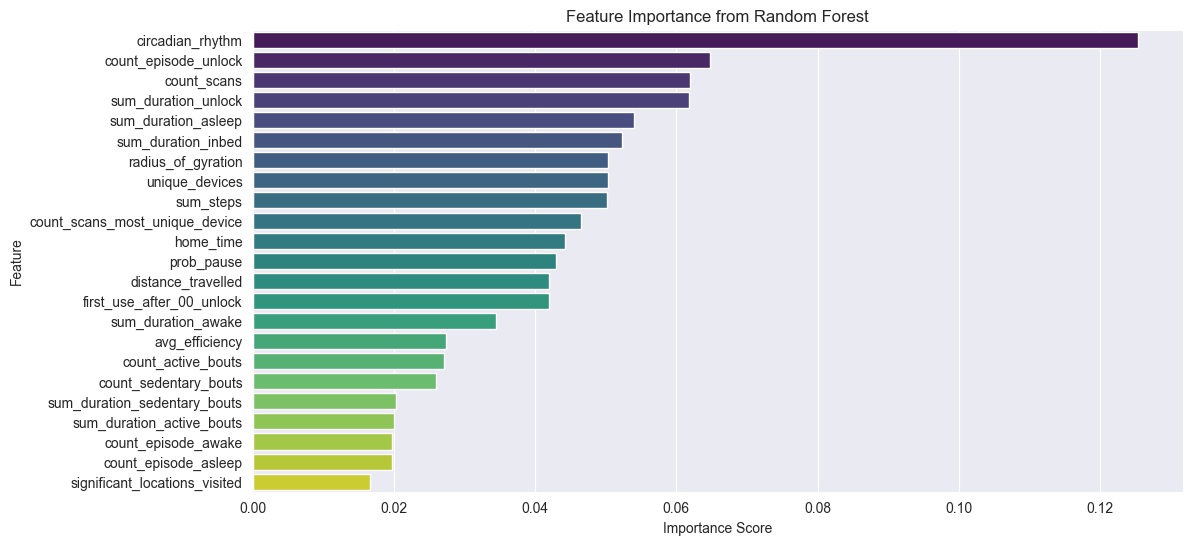

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Prepare the feature matrix and target vector
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score', 'stress_category']]
X = sensor_data[features_columns].values
y = sensor_data['stress_score'].values

# Fit a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Extract and plot feature importances
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=features_columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances_sorted.values, y=feature_importances_sorted.index, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


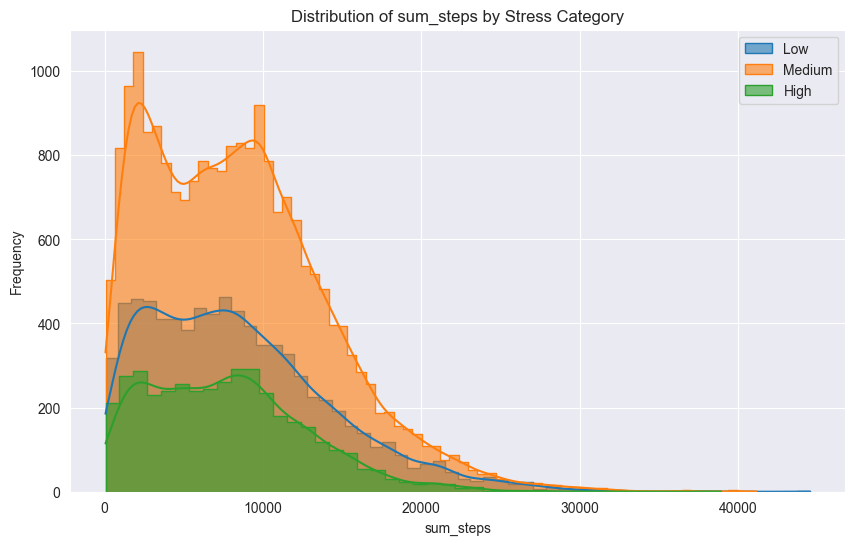

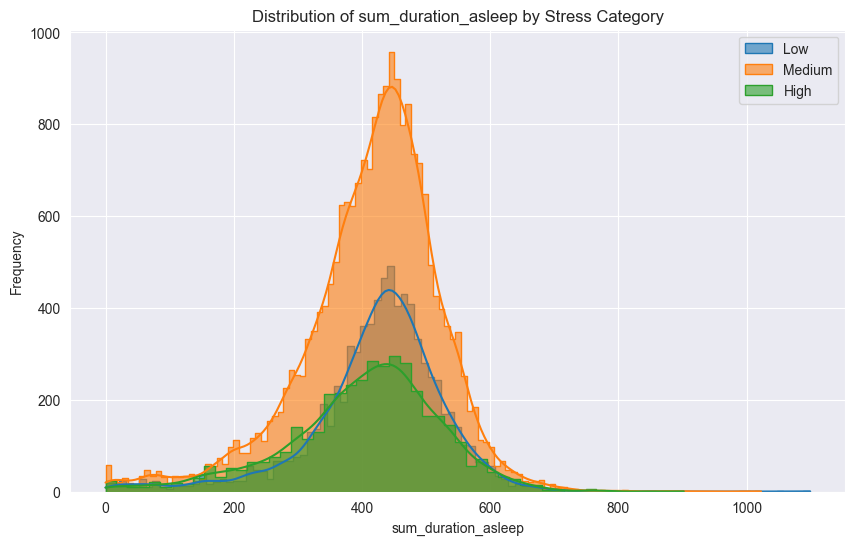

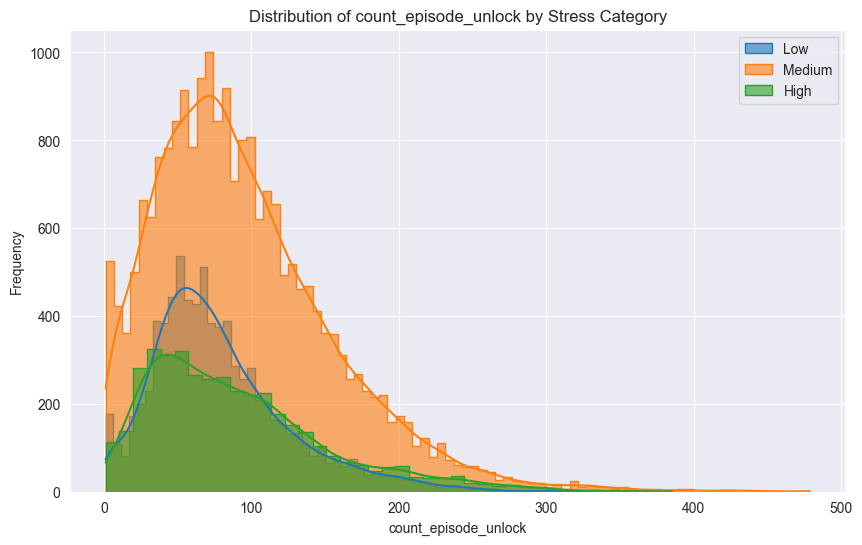

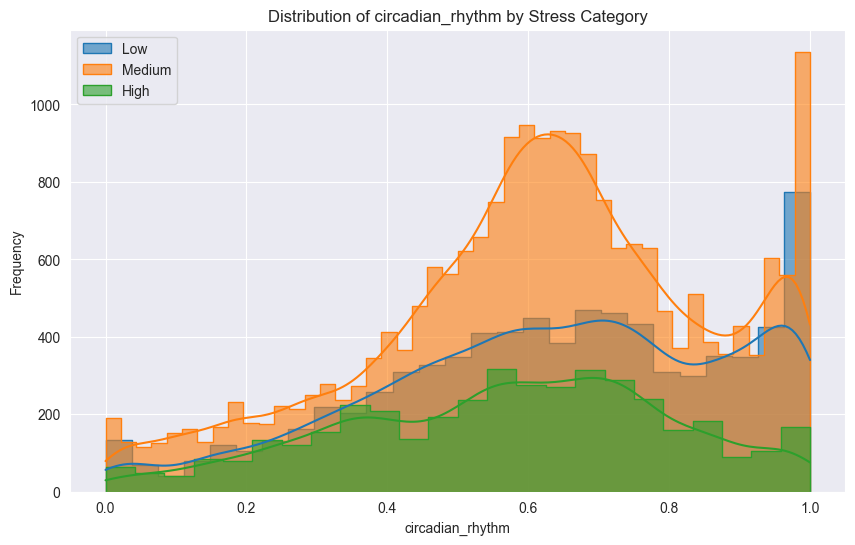

In [29]:
stress_categories = ['Low', 'Medium', 'High']
selected_features = ['sum_steps', 'sum_duration_asleep', 'count_episode_unlock', 'circadian_rhythm', 'count_scans']
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    for category in stress_categories:
        sns.histplot(sensor_data[sensor_data['stress_category'] == category][feature], label=category, kde=True, element='step', alpha=0.6)
    plt.title(f'Distribution of {feature} by Stress Category')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()



Using a Random Forest Regressor to Predict Stress Scores

Mean Squared Error (MSE): 54.3130
R-squared (R^2): -0.0589


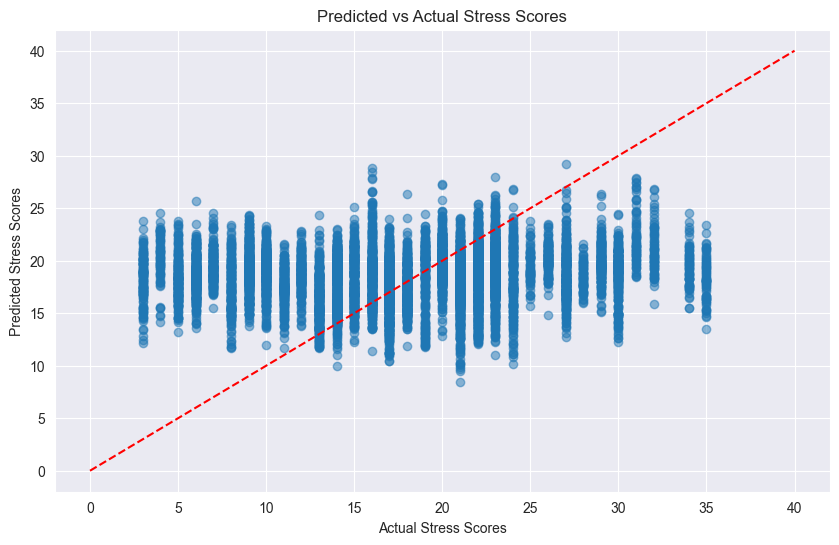

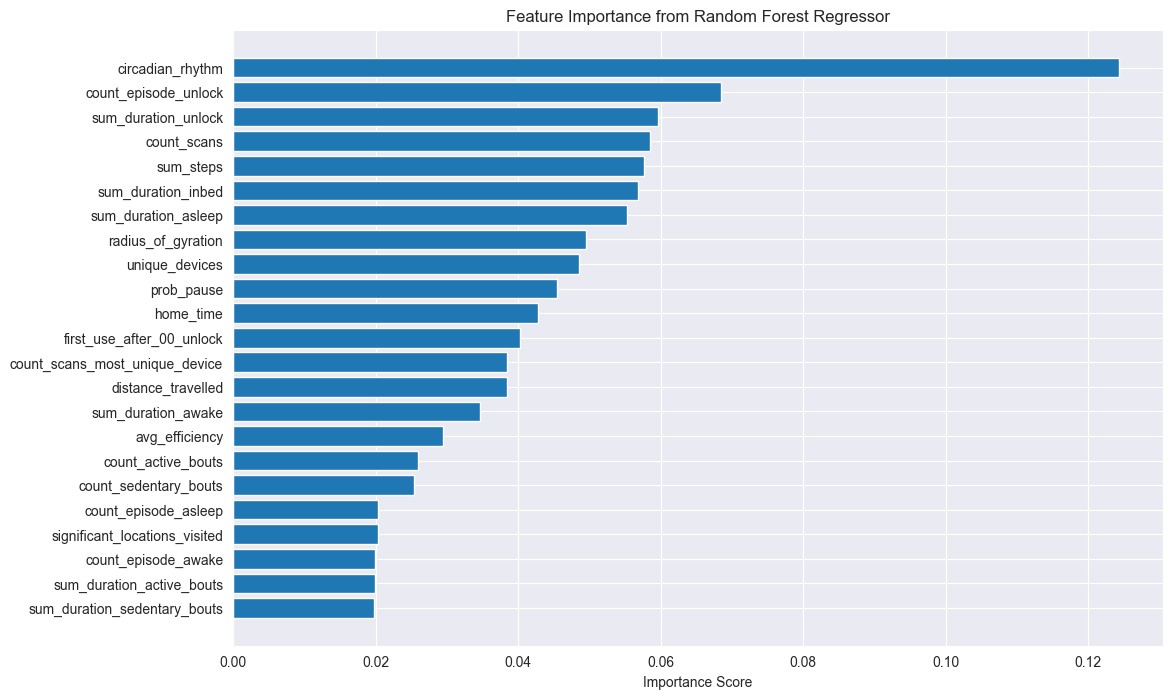

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare training and testing features and targets
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score', 'stress_category']]
X_train = train_data[features_columns].values
y_train = train_data['stress_score'].values
X_test = test_data[features_columns].values
y_test = test_data['stress_score'].values

# Instantiate the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R^2): {r2:.4f}')

# Scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Stress Scores')
plt.ylabel('Predicted Stress Scores')
plt.title('Predicted vs Actual Stress Scores')
plt.plot([0, 40], [0, 40], color='red', linestyle='--')  # Reference line
plt.show()

# Feature importance plot
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importance from Random Forest Regressor')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features_columns[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.show()


Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2

/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   2.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, 

/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
432 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
53 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/praneelpanchigar/PycharmProjects/AIforHeal

Best Parameters from GridSearchCV: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error (MSE): 51.4618
R-squared (R^2): -0.0033


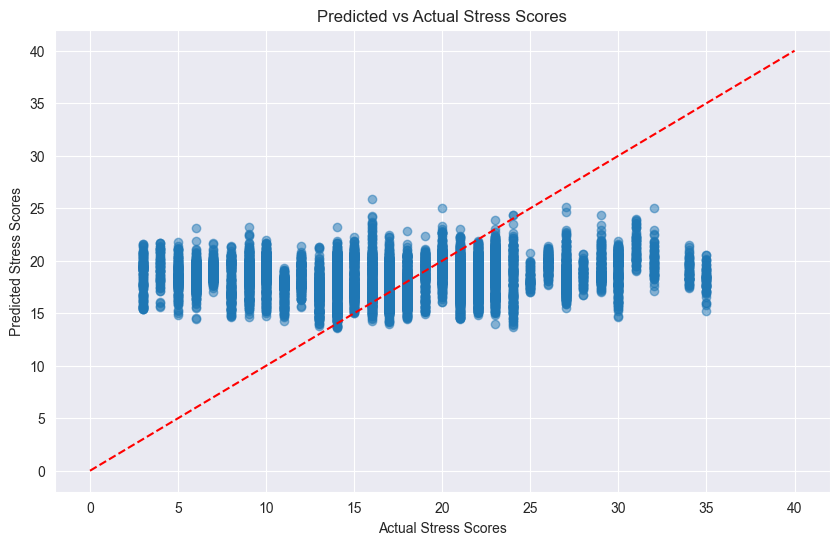

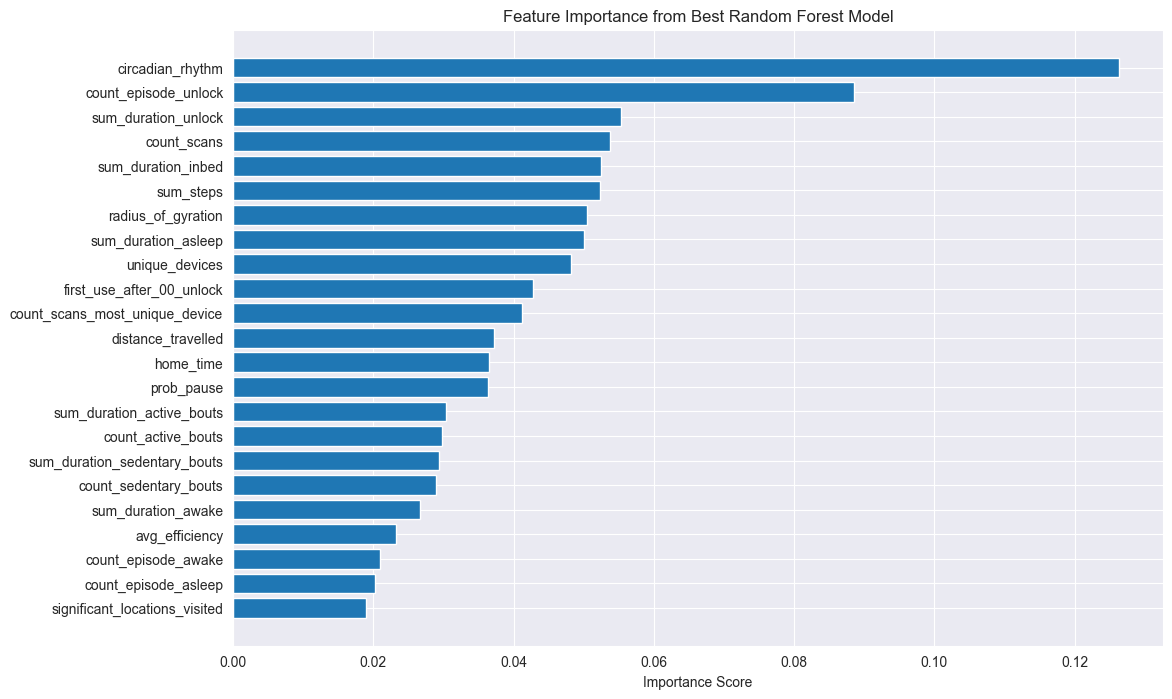

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

# Prepare training and testing features and targets
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score', 'stress_category']]
X_train = train_data[features_columns].values
y_train = train_data['stress_score'].values
X_test = test_data[features_columns].values
y_test = test_data['stress_score'].values

# Scale the data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Random Forest Regressor and Grid Search parameters
rf_regressor = RandomForestRegressor(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [20, 50, 100, 200],       # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider for best split
}

# Set up GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Train the Random Forest with Grid Search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from grid search
best_params = grid_search.best_params_
print("Best Parameters from GridSearchCV:", best_params)

# Predict on the test set using the best model
best_rf_regressor = grid_search.best_estimator_
y_pred = best_rf_regressor.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R^2): {r2:.4f}')

# Scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Stress Scores')
plt.ylabel('Predicted Stress Scores')
plt.title('Predicted vs Actual Stress Scores')
plt.plot([0, 40], [0, 40], color='red', linestyle='--')  # Reference line
plt.show()

# Feature importance plot
importances = best_rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importance from Best Random Forest Model')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features_columns[i] for i in indices])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.show()


Epoch [1/100], Loss: 376.1991
Test Loss: 343.1208
Epoch [2/100], Loss: 379.6160
Test Loss: 343.1208
Epoch [3/100], Loss: 386.3086
Test Loss: 343.1208
Epoch [4/100], Loss: 380.8091
Test Loss: 343.1208
Epoch [5/100], Loss: 383.4992
Test Loss: 343.1208
Epoch [6/100], Loss: 384.7955
Test Loss: 343.1208
Epoch [7/100], Loss: 386.7208
Test Loss: 343.1208
Epoch [8/100], Loss: 393.4081
Test Loss: 343.1208
Epoch [9/100], Loss: 387.8977
Test Loss: 343.1208
Epoch [10/100], Loss: 386.1676
Test Loss: 343.1208
Epoch [11/100], Loss: 372.9504
Test Loss: 343.1208
Epoch [12/100], Loss: 374.4853
Test Loss: 343.1208
Epoch [13/100], Loss: 383.9385
Test Loss: 343.1208
Epoch [14/100], Loss: 386.6449
Test Loss: 343.1208
Epoch [15/100], Loss: 381.8450
Test Loss: 343.1208
Epoch [16/100], Loss: 388.8577
Test Loss: 343.1208
Epoch [17/100], Loss: 376.0364
Test Loss: 343.1208
Epoch [18/100], Loss: 385.6144
Test Loss: 343.1208
Epoch [19/100], Loss: 382.6532
Test Loss: 343.1208
Epoch [20/100], Loss: 381.8505
Test Loss

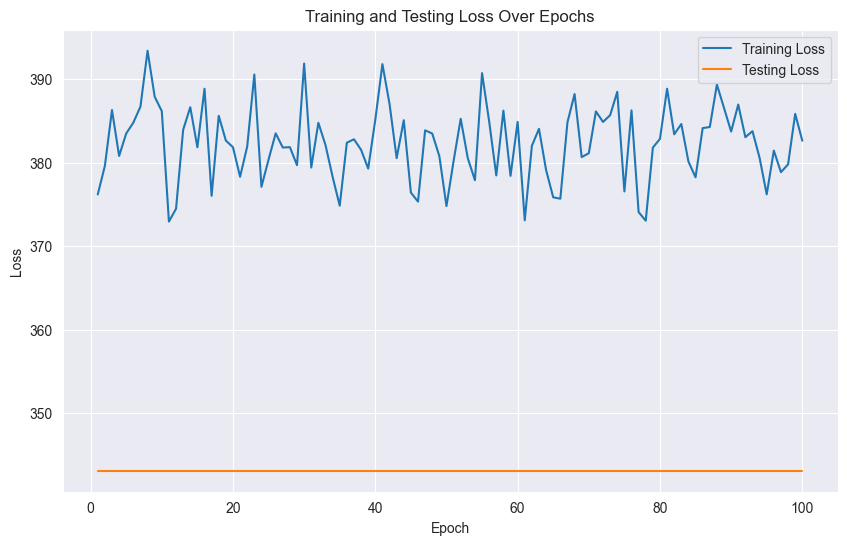

Final Test Loss: 343.1208


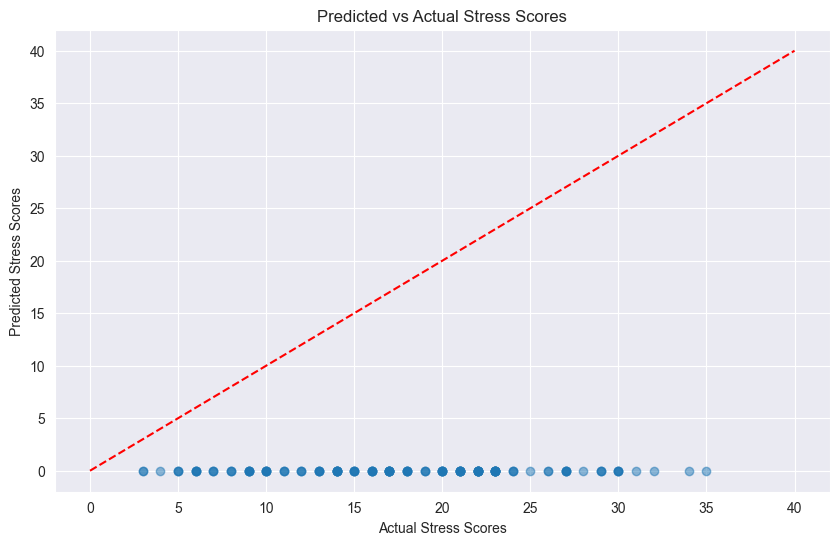

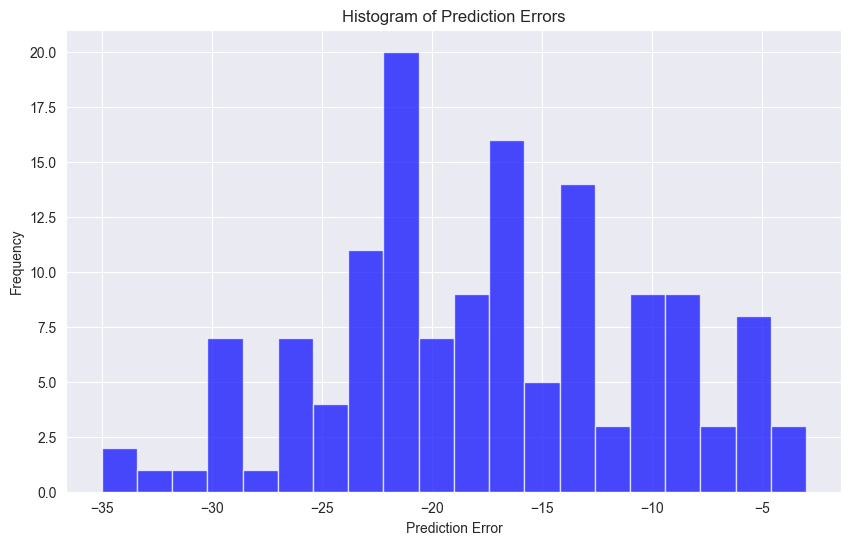

In [10]:
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model
class StressLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(StressLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)  # We don't need the hidden state
        # Only use the last output of the sequence for prediction
        last_output = lstm_out[:, -1, :]
        # Fully connected layer to map to output size
        out = self.fc(last_output)
        # Clamp and round the output for stress scores between 0 and 40
        out = torch.clamp(out, 0, 40)
        out = torch.round(out)
        return out

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model hyperparameters
input_size = X_train_tensor.shape[2]  # Number of features
hidden_size = 64  # Size of LSTM hidden layer
output_size = 1  # Predicting stress score as a single value
num_layers = 6  # Single LSTM layer to keep things simple

# Instantiate the model, define loss function and optimizer
model = StressLSTM(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch.squeeze())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}')

    # Evaluate on test set at the end of each epoch
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.squeeze())
            test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f'Test Loss: {avg_test_loss:.4f}')

# Plot training and testing loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    test_loss = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch.squeeze())
        test_loss += loss.item()

        all_preds.extend(outputs.squeeze().cpu().numpy())
        all_targets.extend(y_batch.squeeze().cpu().numpy())

    print(f'Final Test Loss: {test_loss/len(test_loader):.4f}')

# Scatter plot of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.xlabel('Actual Stress Scores')
plt.ylabel('Predicted Stress Scores')
plt.title('Predicted vs Actual Stress Scores')
plt.plot([0, 40], [0, 40], color='red', linestyle='--')  # Reference line
plt.show()

# Histogram of prediction errors (residuals)
residuals = [pred - target for pred, target in zip(all_preds, all_targets)]
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


## Classification Based Approach   

# Summary of the Classification Approach for Stress Level Prediction

## Goal:
To classify stress levels into three categories: Low, Medium, and High, based on sensor data.

### 1. Data Preparation
- **Dataset**: We started with the cleaned, non-normalized sensor dataset.
- **Target Transformation**: Stress scores were converted into categories (Low, Medium, High) using binning.
- **Feature and Target Extraction**: The features used include various sensor metrics, while the target variable was the stress category.
- **Train-Test Split**: We used the year 2021 data as the test set and the rest as the training set to evaluate the model's ability to generalize over time.
- **Class Imbalance Handling**: We observed a significant imbalance in class distribution, with the 'Medium' category dominating. To address this, we used **SMOTE** (Synthetic Minority Oversampling Technique) to balance the training set.

### 2. Data Scaling
- **RobustScaler**: This scaler was chosen due to the potential presence of outliers, making it more robust for datasets with fat tails compared to other scalers like MinMaxScaler.

### 3. Models Attempted
- We experimented with various models to assess their performance in classifying stress levels.

#### a. Tree-Based Models
- **Random Forest** and **XGBoost** were selected for their robustness and ability to capture complex relationships without extensive feature engineering.
- **GridSearchCV** was used to identify the best hyperparameters, and **Stratified K-Fold Cross-Validation** ensured that class imbalance was handled during training.

#### b. Logistic Regression
- Used as a baseline to compare performance with more complex models. It provided insight into how well a simpler linear model performs.

#### c. Support Vector Machine (SVM)
- Tested to see if the non-linear relationships between the features and target could be captured using kernel tricks.

#### d. Multilayer Perceptron (MLP)
- Implemented to evaluate a neural network model, which is effective for capturing non-linear relationships.

### 4. Model Evaluation
- Metrics used for evaluating each model included **Accuracy**, **Precision**, **Recall**, **F1-Score**, and **ROC-AUC**.
- Given the class imbalance, metrics like Precision, Recall, F1-Score, and ROC-AUC were emphasized over Accuracy.
- **Confusion Matrix**: Plotted for each model to visually assess the class-wise prediction performance.
- **Performance Comparisons**: A bar plot showing **F1-Score** for all models was generated to compare their performances effectively.

### 5. Summary of Findings
- Tree-based models (Random Forest and XGBoost) showed the best potential for this classification problem, while logistic regression served as a useful baseline.
- The class imbalance was handled with SMOTE to ensure fair representation across classes, improving the models' ability to predict minority classes effectively.
- Overall, we aimed to strike a balance between model complexity and interpretability, evaluating simpler models first before moving to more complex neural networks and ensemble methods.



Model: Random Forest
Accuracy: 0.49879275653923544
Precision: 0.44732725703350384
Recall: 0.49879275653923544
F1-Score: 0.46244158639041655
ROC-AUC Score: 0.5098270801834639


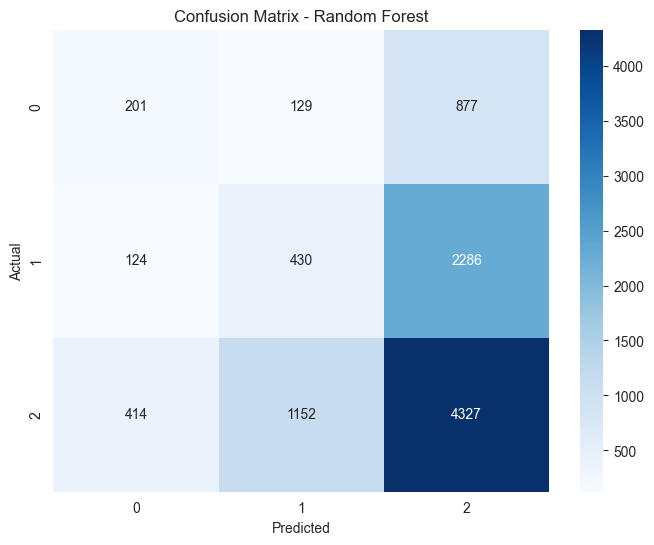

/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:34:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:34:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:34:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:34:54] WARNING: /Users/runner/work


Model: XGBoost
Accuracy: 0.5038229376257545
Precision: 0.42783716500569324
Recall: 0.5038229376257545
F1-Score: 0.4474001061001737
ROC-AUC Score: 0.4706693294306935


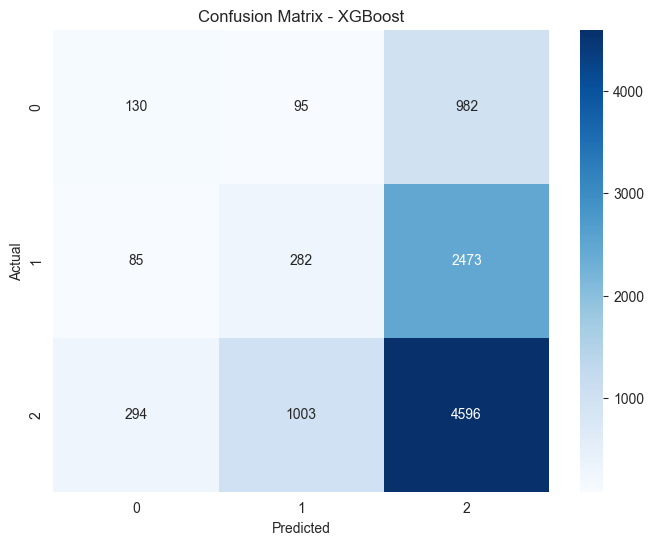

/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/linear_model


Model: Logistic Regression
Accuracy: 0.2535211267605634
Precision: 0.43778786674614223
Recall: 0.2535211267605634
F1-Score: 0.24158287647286583
ROC-AUC Score: 0.5345705958405577


/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


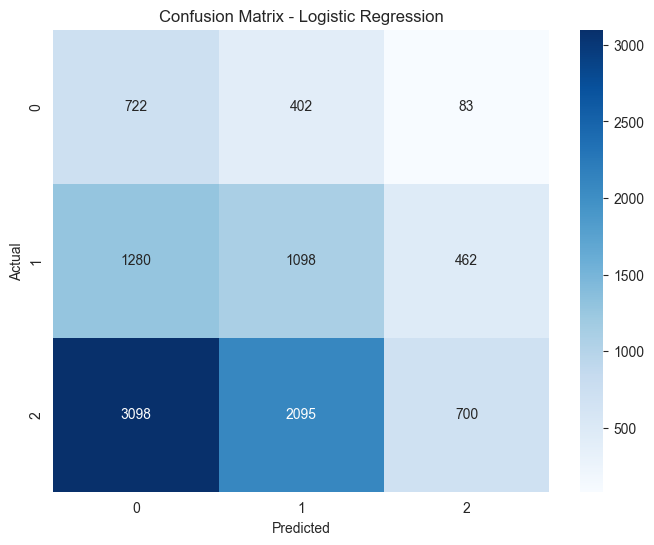

In [ ]:
# Classification Model Implementation for Stress Level Prediction

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Load the cleaned dataset
sensor_data = pd.read_csv('Sensor Data Cleaned/cleaned_non_normalized_final_sensor_stress_data_no_missing.csv')
sensor_data.rename(columns={'PSS_10items_POST': 'stress_score'}, inplace=True)

# Convert stress score to categories (low, medium, high)
sensor_data['stress_category'] = pd.cut(sensor_data['stress_score'], bins=[0, 13, 26, 40], labels=['Low', 'Medium', 'High'])

# Features and Target preparation
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score', 'stress_category']]
X = sensor_data[features_columns]
y = sensor_data['stress_category']

# Convert target labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split (2021 as testing set)
sensor_data['year'] = pd.to_datetime(sensor_data['date']).dt.year
train_data = sensor_data[sensor_data['year'] < 2021]
test_data = sensor_data[sensor_data['year'] == 2021]

X_train = train_data[features_columns]
y_train = label_encoder.transform(train_data['stress_category'])
X_test = test_data[features_columns]
y_test = label_encoder.transform(test_data['stress_category'])

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale data using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Helper function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(pd.get_dummies(y_test), model.predict_proba(X_test), average='weighted', multi_class='ovr')
    
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("ROC-AUC Score:", auc)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='g')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Random Forest Classifier with GridSearchCV and Cross-Validation
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'class_weight': ['balanced']
}
cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=cv_rf, scoring='f1_weighted')
grid_search_rf.fit(X_train, y_train)
evaluate_model(grid_search_rf.best_estimator_, X_test, y_test, 'Random Forest')

# XGBoost Classifier with GridSearchCV and Cross-Validation
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}
cv_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_grid_xgb, cv=cv_xgb, scoring='f1_weighted')
grid_search_xgb.fit(X_train, y_train)
evaluate_model(grid_search_xgb.best_estimator_, X_test, y_test, 'XGBoost')

# Logistic Regression with GridSearchCV and Cross-Validation
param_grid_log = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000]
}
cv_log = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_log = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced', multi_class='ovr'), param_grid_log, cv=cv_log, scoring='f1_weighted')
grid_search_log.fit(X_train, y_train)
evaluate_model(grid_search_log.best_estimator_, X_test, y_test, 'Logistic Regression')

# Support Vector Machine Classifier with GridSearchCV and Cross-Validation
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}
cv_svc = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_svc = GridSearchCV(SVC(probability=True, random_state=42, class_weight='balanced'), param_grid_svc, cv=cv_svc, scoring='f1_weighted')
grid_search_svc.fit(X_train, y_train)
evaluate_model(grid_search_svc.best_estimator_, X_test, y_test, 'Support Vector Machine')

# Multilayer Perceptron (MLP) Classifier with GridSearchCV and Cross-Validation
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (150, 150)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01]
}
cv_mlp = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_mlp = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), param_grid_mlp, cv=cv_mlp, scoring='f1_weighted')
grid_search_mlp.fit(X_train, y_train)
evaluate_model(grid_search_mlp.best_estimator_, X_test, y_test, 'Multilayer Perceptron')

# Note: Accuracy can be misleading if classes are imbalanced. Pay more attention to metrics like Precision, Recall, and F1-score.

# Visualizing Model Comparisons
models = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Support Vector Machine', 'Multilayer Perceptron']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
performance_data = []

for model, estimator in zip(models, [grid_search_rf.best_estimator_, grid_search_xgb.best_estimator_, grid_search_log.best_estimator_, grid_search_svc.best_estimator_, grid_search_mlp.best_estimator_]):
    y_pred = estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(pd.get_dummies(y_test), estimator.predict_proba(X_test), average='weighted', multi_class='ovr')
    performance_data.append([model, accuracy, precision, recall, f1, auc])

performance_df = pd.DataFrame(performance_data, columns=['Model'] + metrics)

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='F1-Score', data=performance_df)
plt.title('Model Comparison by F1-Score')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.show()

print(performance_df)



Model: Random Forest
Accuracy: 0.49748490945674045
Precision: 0.4478893069089788
Recall: 0.49748490945674045
F1-Score: 0.462872000041874
ROC-AUC Score: 0.5097241034392728


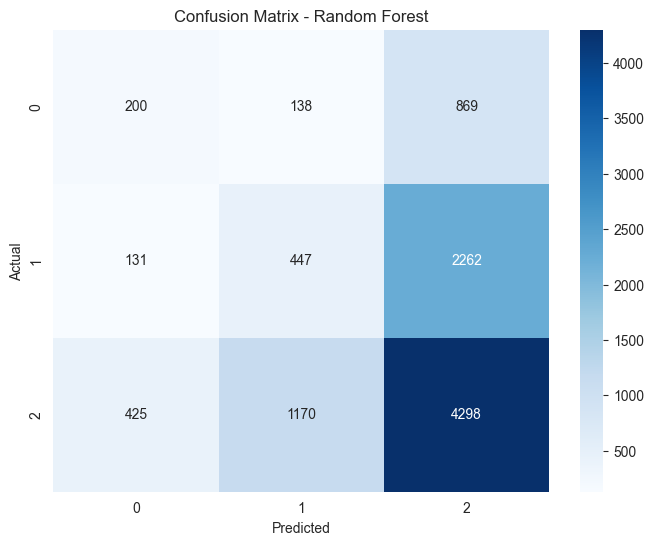

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

# Load the cleaned dataset
sensor_data = pd.read_csv('Sensor Data Cleaned/cleaned_non_normalized_final_sensor_stress_data_no_missing.csv')
sensor_data.rename(columns={'PSS_10items_POST': 'stress_score'}, inplace=True)

# Convert stress score to categories (low, medium, high)
sensor_data['stress_category'] = pd.cut(sensor_data['stress_score'], bins=[0, 13, 26, 40], labels=['Low', 'Medium', 'High'])

# Features and Target preparation
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score', 'stress_category']]
X = sensor_data[features_columns]
y = sensor_data['stress_category']

# Convert target labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split (2021 as testing set)
sensor_data['year'] = pd.to_datetime(sensor_data['date']).dt.year
train_data = sensor_data[sensor_data['year'] < 2021]
test_data = sensor_data[sensor_data['year'] == 2021]

X_train = train_data[features_columns]
y_train = label_encoder.transform(train_data['stress_category'])
X_test = test_data[features_columns]
y_test = label_encoder.transform(test_data['stress_category'])

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale data using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Helper function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(pd.get_dummies(y_test), model.predict_proba(X_test), average='weighted', multi_class='ovr')
    
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("ROC-AUC Score:", auc)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='g')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Random Forest Classifier with RandomizedSearchCV and Cross-Validation
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'class_weight': ['balanced']
}
cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=5, cv=cv_rf, scoring='f1_weighted', n_jobs=-1)
random_search_rf.fit(X_train, y_train)
evaluate_model(random_search_rf.best_estimator_, X_test, y_test, 'Random Forest')



In [ ]:
# XGBoost Classifier with RandomizedSearchCV and Cross-Validation
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}
cv_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_xgb = RandomizedSearchCV(XGBClassifier(random_state=42, eval_metric='mlogloss'), param_distributions=param_dist_xgb, n_iter=5, cv=cv_xgb, scoring='f1_weighted', n_jobs=-1)
random_search_xgb.fit(X_train, y_train)
evaluate_model(random_search_xgb.best_estimator_, X_test, y_test, 'XGBoost')



In [ ]:
# Logistic Regression with RandomizedSearchCV and Cross-Validation
param_dist_log = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000]
}
cv_log = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_log = RandomizedSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param_distributions=param_dist_log, n_iter=5, cv=cv_log, scoring='f1_weighted', n_jobs=-1)
random_search_log.fit(X_train, y_train)
evaluate_model(random_search_log.best_estimator_, X_test, y_test, 'Logistic Regression')


In [ ]:

# Support Vector Machine Classifier with RandomizedSearchCV and Cross-Validation
param_dist_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}
cv_svc = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_svc = RandomizedSearchCV(SVC(probability=True, random_state=42, class_weight='balanced'), param_distributions=param_dist_svc, n_iter=5, cv=cv_svc, scoring='f1_weighted', n_jobs=-1)
random_search_svc.fit(X_train, y_train)
evaluate_model(random_search_svc.best_estimator_, X_test, y_test, 'Support Vector Machine')



In [ ]:
# Multilayer Perceptron (MLP) Classifier with RandomizedSearchCV and Cross-Validation
param_dist_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (150, 150)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01]
}
cv_mlp = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_mlp = RandomizedSearchCV(MLPClassifier(max_iter=1000, random_state=42), param_distributions=param_dist_mlp, n_iter=5, cv=cv_mlp, scoring='f1_weighted', n_jobs=-1)
random_search_mlp.fit(X_train, y_train)
evaluate_model(random_search_mlp.best_estimator_, X_test, y_test, 'Multilayer Perceptron')

# Note: Accuracy can be misleading if classes are imbalanced. Pay more attention to metrics like Precision, Recall, and F1-score.



Model: Random Forest
Accuracy: 0.5583501006036218
Precision: 0.45789335040751816
Recall: 0.5583501006036218
F1-Score: 0.4524339102288637
ROC-AUC Score: 0.5006218866047841


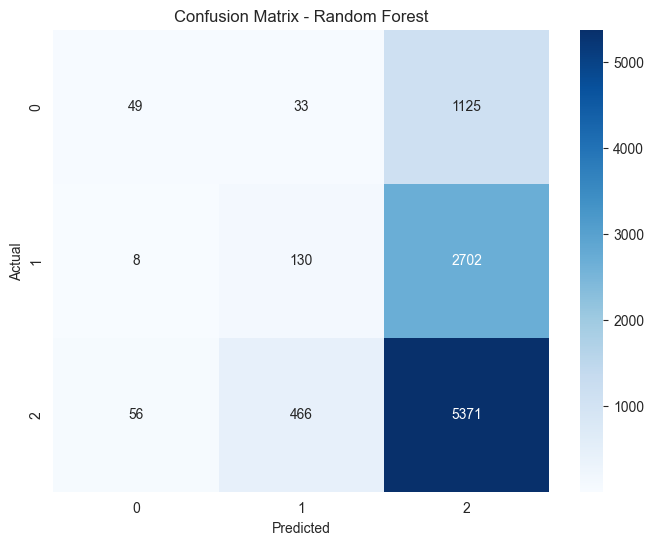


Model: XGBoost
Accuracy: 0.5258551307847082
Precision: 0.42097334157611543
Recall: 0.5258551307847082
F1-Score: 0.4437517239261363
ROC-AUC Score: 0.4871070804190769


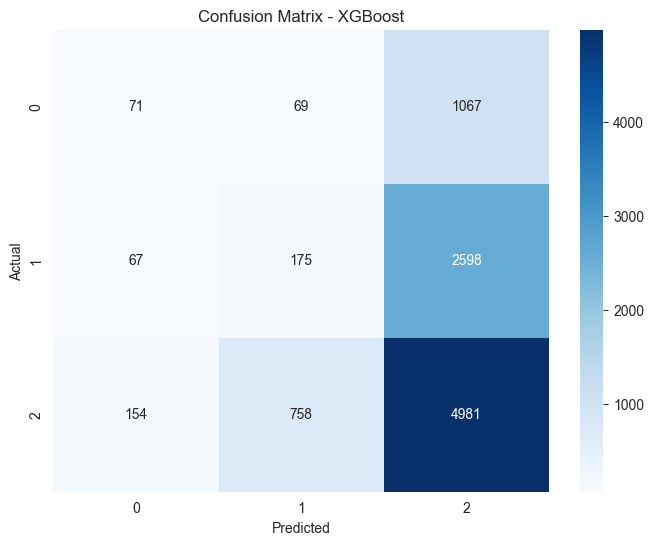


Model: Logistic Regression
Accuracy: 0.263682092555332
Precision: 0.4479468228023076
Recall: 0.263682092555332
F1-Score: 0.258149066615256
ROC-AUC Score: 0.5248880024528738


/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


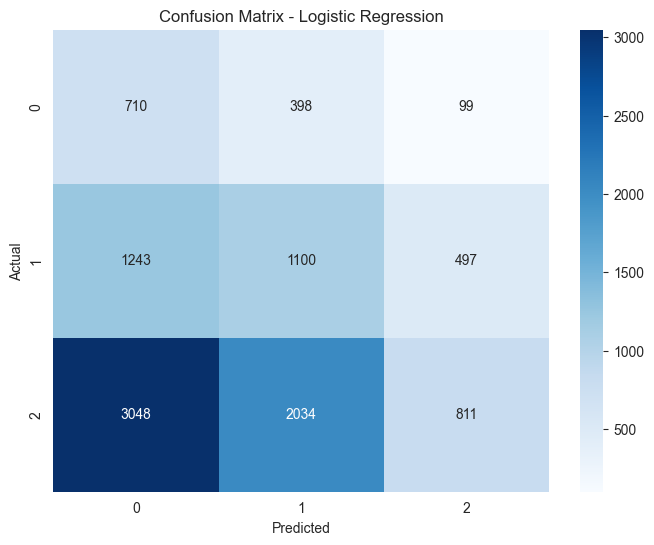


Model: Support Vector Machine
Accuracy: 0.2528169014084507
Precision: 0.45163342020100217
Recall: 0.2528169014084507
F1-Score: 0.22772949573604434
ROC-AUC Score: 0.5087060895843278


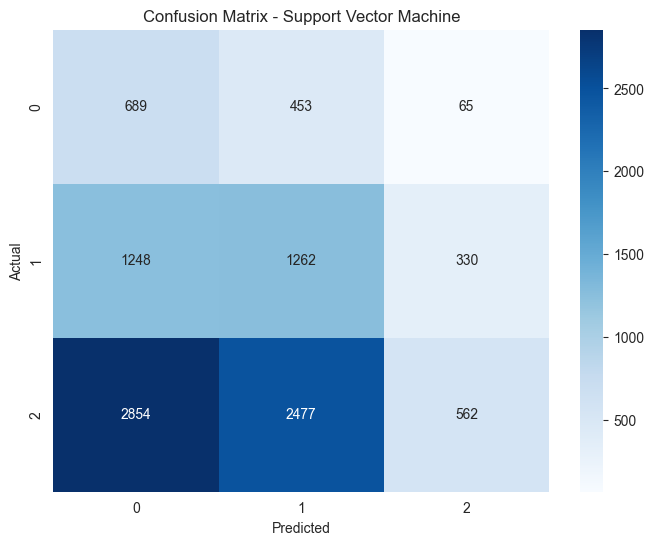


Model: Multilayer Perceptron
Accuracy: 0.464989939637827
Precision: 0.44460495979987
Recall: 0.464989939637827
F1-Score: 0.45143971631542057
ROC-AUC Score: 0.5031291212988758


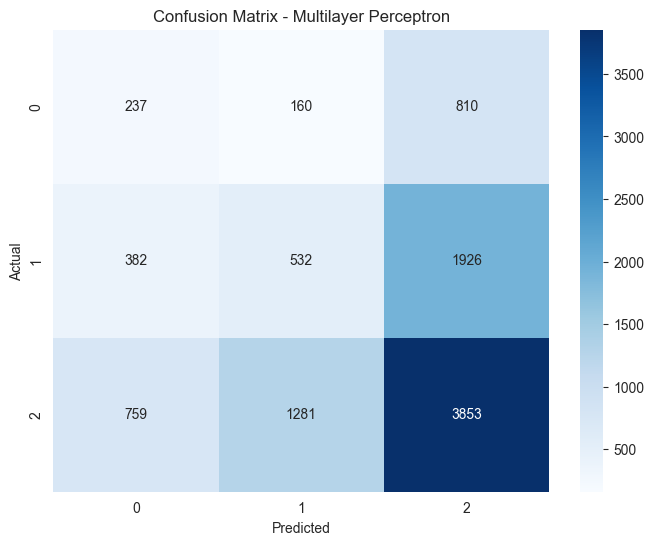

In [6]:
# Load the cleaned dataset
sensor_data = pd.read_csv('Sensor Data Cleaned/cleaned_non_normalized_final_sensor_stress_data_no_missing.csv')
sensor_data.rename(columns={'PSS_10items_POST': 'stress_score'}, inplace=True)

# Convert stress score to categories (low, medium, high)
sensor_data['stress_category'] = pd.cut(sensor_data['stress_score'], bins=[0, 13, 26, 40], labels=['Low', 'Medium', 'High'])

# Features and Target preparation
features_columns = [col for col in sensor_data.columns if col not in ['pid', 'date', 'year', 'stress_score', 'stress_category']]
X = sensor_data[features_columns]
y = sensor_data['stress_category']

# Convert target labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split (2021 as testing set)
sensor_data['year'] = pd.to_datetime(sensor_data['date']).dt.year
train_data = sensor_data[sensor_data['year'] < 2021]
test_data = sensor_data[sensor_data['year'] == 2021]

X_train = train_data[features_columns]
y_train = label_encoder.transform(train_data['stress_category'])
X_test = test_data[features_columns]
y_test = label_encoder.transform(test_data['stress_category'])

# Apply SMOTE to balance the training data
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale data using RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Helper function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(pd.get_dummies(y_test), model.predict_proba(X_test), average='weighted', multi_class='ovr')
    
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("ROC-AUC Score:", auc)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='g')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, 'Random Forest')

# XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, 'XGBoost')

# Logistic Regression
log_model = LogisticRegression(C=1, max_iter=500, random_state=42, class_weight='balanced')
log_model.fit(X_train, y_train)
evaluate_model(log_model, X_test, y_test, 'Logistic Regression')

# Support Vector Machine Classifier
svc_model = SVC(C=1, kernel='rbf', probability=True, random_state=42, class_weight='balanced')
svc_model.fit(X_train, y_train)
evaluate_model(svc_model, X_test, y_test, 'Support Vector Machine')

# Multilayer Perceptron (MLP) Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', learning_rate_init=0.001, max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)
evaluate_model(mlp_model, X_test, y_test, 'Multilayer Perceptron')
